<h1>DREAMS Spindle Extraction</h1>

This notebook serves as an extension to the spindle extraction procedure performed on the Physionet dataset. The DREAMS database was collected during the DREAMS project to tune and test automatic spindle detection algorithms. For further details, the link to the database and the overall DREAMS project description are in the links below:

<b>The DREAMS Sleep Spindles Database</b>

http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseSpindles/

<b>The DREAMS Project</b>

http://www.tcts.fpms.ac.be/projects/dreams/#description

<h2>Loading The Datasets Preliminary Pre-Processing</h2>

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt

# Import EDF file libraries:
import mne
import pyedflib

# Set up seaborn
import seaborn as sns
sns.set()

In [2]:
# Assign variable with filepath to the dreams folder in local drive:
filepath = "C:\\Users\\Jason Ha\\Documents\\University\\4th Year\\Thesis Project (Repo)\\Jupyter Notebooks\\dreams\\DatabaseSpindles"

# Request for EDF filename from user
edf_file = input("Enter the PSG file (with file extension, .txt or .edf): ")

# Check whether an .EDF file was entered or a .txt file:
if ".edf" in edf_file:
    # Append edf_file to filepath:
    total_filepath = filepath + "\\" + edf_file
    # Load the file using pyedflib:
    raw = mne.io.read_raw_edf(total_filepath)
else:
    # Append edf_file to filepath:
    total_filepath = filepath + "\\" + edf_file
    # Load using pandas:
    raw = pd.read_csv(total_filepath, sep='\n')

    
# Request For Spindle Annotations (By Expert):
spindle_marks = input("Enter name of the .txt file containing the detected spindles: ")
temp = filepath + "\\" + spindle_marks
expert_spindles = pd.read_csv(temp, sep='\t').reset_index()
expert_spindles.columns = ['time', 'duration']

Enter the PSG file (with file extension, .txt or .edf): excerpt1.txt
Enter name of the .txt file containing the detected spindles: Visual_scoring1_excerpt2.txt


In [3]:
raw = np.array(raw).flatten().T
total_samples = len(raw)
sampling_freq = input("Enter The Sampling Frequency Of Excerpt: ")
sampling_freq = int(sampling_freq)

Enter The Sampling Frequency Of Excerpt: 100


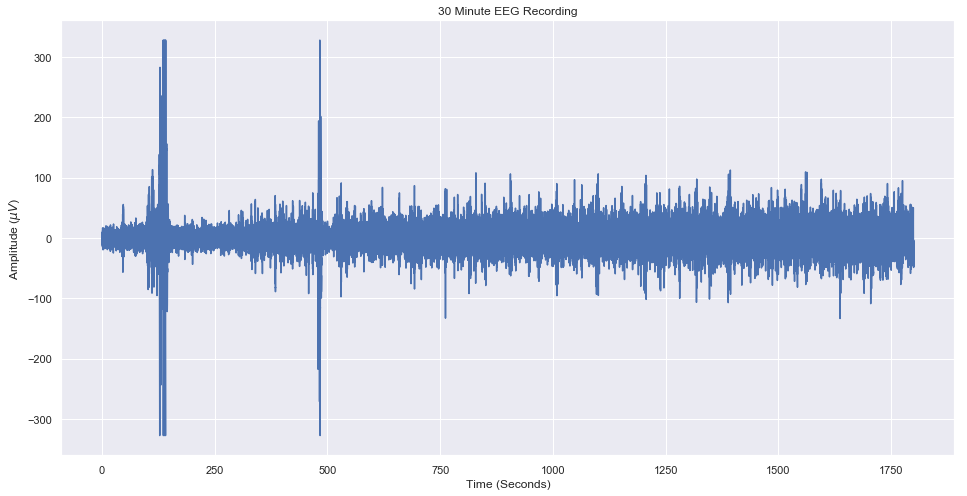

In [4]:
# Apply matplotlib inline magic
%matplotlib inline

# Instantiate an empty matplotlib figure
fig = plt.figure(figsize=(16,8))

# Obtain the time axis for the signal. We are given that fs = 100Hz
max_time = total_samples / sampling_freq
t = np.arange(0, max_time, 1/sampling_freq)

# Plot the raw signal against the time
plt.xlabel("Time (Seconds)")
plt.ylabel("Amplitude ($\mu V$)")
plt.title("30 Minute EEG Recording")
plt.plot(t, raw)

# Show final plot
plt.show()

<h2>Spindle Detection With Expert Markings</h2>

In [5]:
expert_spindles.head()

,time,duration
0,0.80,0.80
1,6.96,1.26
2,22.98,0.85
3,26.09,1.28
4,31.50,0.74


In [6]:
microevents_start = (np.array(expert_spindles['time']) * 100).astype(int)
microevents_duration = (np.array(expert_spindles['duration']) * 100).astype(int)
microevents_end = np.sum([microevents_start, microevents_duration], axis=0)

# Create a dataframe from the start and end arrays
d = {'start':microevents_start, 'end':microevents_end}
spindle_events = pd.DataFrame(data=d)
spindle_events = spindle_events.values

In [7]:
print(spindle_events[0:10])

[[   80   160]
 [  696   822]
 [ 2298  2383]
 [ 2609  2737]
 [ 3150  3224]
 [ 3446  3502]
 [ 3883  3987]
 [ 8759  8842]
 [ 9263  9322]
 [10926 11002]]


Plotting the signal with the microevent locations on the plot as well:

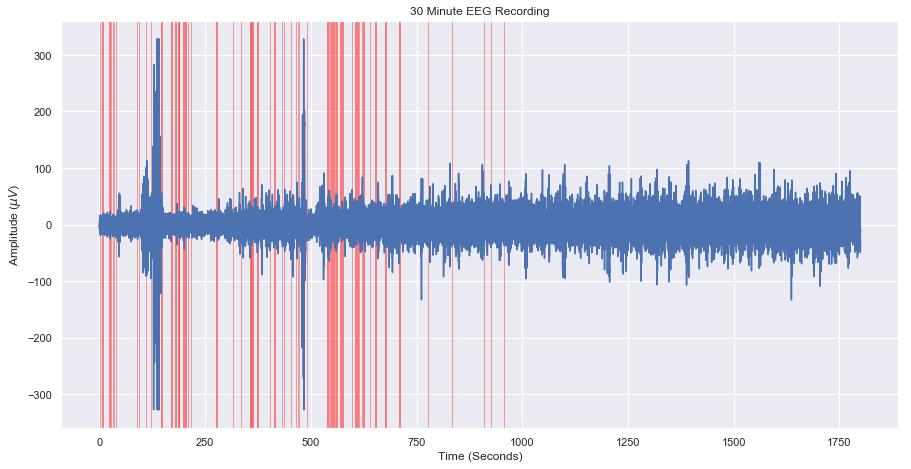

In [8]:
# Apply matplotlib inline magic
%matplotlib inline

# Instantiate an empty matplotlib figure
fig = plt.figure(figsize=(15,7.5))

# Obtain the time axis for the signal. We are given that fs = 100Hz
max_time = total_samples / sampling_freq
t = np.arange(0, max_time, 1/sampling_freq)

# Plot the raw signal against the time
plt.xlabel("Time (Seconds)")
plt.ylabel("Amplitude ($\mu V$)")
plt.title("30 Minute EEG Recording")
plt.plot(t, raw)

# Plotting all the microevents:
for event in np.arange(len(spindle_events)):
    plt.axvspan(spindle_events[event][0]/100, spindle_events[event][1]/100, alpha=0.35, color='red')  
    
# Show final plot
plt.show()

We can create a bandpass filter to retain only the 13Hz component of the extracte spindle above. This way, we can rid of all other relatively slower and faster components (noise) of the marked spindle.

In [9]:
from scipy.signal import butter, lfilter, sosfilt, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b,a = butter(order, [low, high], btype='band', output='ba')
    return b,a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b,a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, padlen=25)
    return y

<h2>Extracting The Spindles</h2>

In [282]:
print("There are {} events in {}\n".format(len(spindle_events), spindle_marks))
event = input("Enter event number (0-{}) ".format(len(spindle_events) - 1))
padding_left = input("How much left padding? ")
padding_left = int(padding_left)
padding_right = input("How much right padding? ")
padding_right = int(padding_right)

There are 60 events in Visual_scoring1_excerpt2.txt

Enter event number (0-59) 20
How much left padding? 50
How much right padding? 50


In [283]:
event = int(event)

# Pull out a spindle from the spindle_events 2D array:
marked_spindle = raw[(spindle_events[event][0]) : (spindle_events[event][1])]
marked_spindle_with_padding = raw[(spindle_events[event][0] - padding_left) : (spindle_events[event][1] + padding_right)]

# Length of marked_spindle:
print(padding_left)
print(padding_right)
print(len(marked_spindle))

50
50
65


In [284]:
print("Duration Of Microevent = {} seconds".format((spindle_events[event][1]-spindle_events[event][0])/100))

Duration Of Microevent = 0.65 seconds


<h3>Plotting The Raw and Filtered Spindle</h3>


In [285]:
fl = int(input("Enter Lower Cutoff Frequency "))
fh = int(input("Enter Higher Cutoff Frequency "))

Enter Lower Cutoff Frequency 11
Enter Higher Cutoff Frequency 16


In [286]:
# Filter the raw spindle:
marked_spindle_filtered = butter_bandpass_filter(marked_spindle, fl, fh, 100, order=3)
marked_spindle_filtered_with_pad = butter_bandpass_filter(marked_spindle_with_padding, fl, fh, 100, order=3)

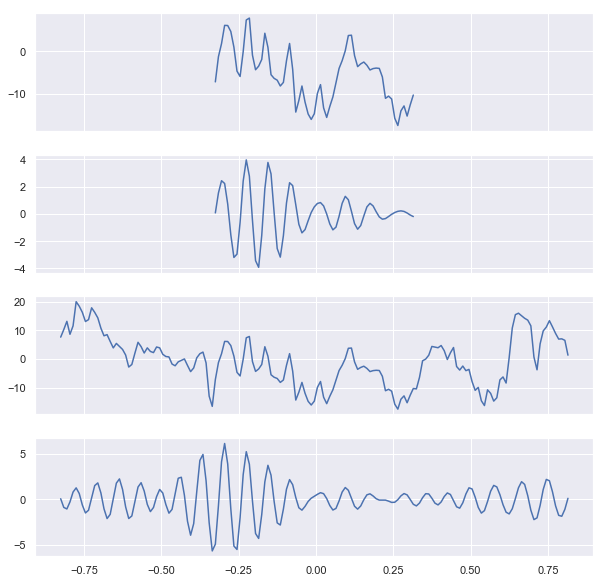

In [287]:
# Instantiate figure:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, ncols=1, figsize=(10,10), sharex=True)

# Create the time-axis:
tmp = len(marked_spindle)
tmp_with_pad = len(marked_spindle_with_padding)
t = np.arange(-tmp/200, (tmp - 1)/200, 1/100)
t_with_pad = np.arange(-tmp_with_pad/200, (tmp_with_pad - 1)/200, 1/100)

# Plot the marked spindle
ax0.plot(t, raw[(spindle_events[event][0]) : (spindle_events[event][1])])
ax1.plot(t, marked_spindle_filtered)
ax2.plot(t_with_pad, marked_spindle_with_padding)
ax3.plot(t_with_pad, marked_spindle_filtered_with_pad)

# Show the plot:
plt.show()

In [ ]:
print("The actual spindle may be better defined from the EEG epoch WITH padding.\n")
option = int(input("Use the expert's spindle (1) or a modified time interval (2)? "))

if option == 1:
    print("Proceed to fitting the QPS model...")
elif option == 2:
    print("Use a modified time-interval from epoch with padding\n.")

<h2>Fitting The QPS Model</h2>

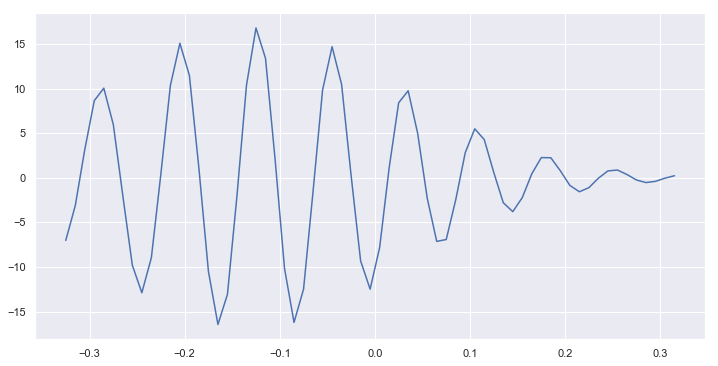

In [288]:
# Instantiate QPS model:
from wavelet_generator import qps_time_sig

# Generate the QPS model:
tmp = len(marked_spindle) 
t_qps = np.arange(-tmp/200, (tmp -1)/200, 1/100)
model = qps_time_sig(t_qps, a=2.5, b=-5.15, c=-20, d=35, e=81.681, f=13.6)

# Plot the prototype QPS model:
fig = plt.figure(figsize=(12,6))
plt.plot(t_qps, model)
plt.show()

In [289]:
from lmfit import Parameters, minimize

def residual(params, t, data):
    a, b, c = params['a'], params['b'], params['c']
    d, e, f = params['d'], params['e'], params['f']

    model = np.exp(a + b*t + c*t**2) * np.cos(d + e*t + f*t**2)
    chi = (data - model)
    
    return chi

# Set up an empty set of parameters:
# a=2.5, b=+1.15, c=-20, d=35, e=81.681, f=13.5
params = Parameters()
params.add('a', value=2.5)
params.add('b', value=+1.15)
params.add('c', value=-20)
params.add('d', value=35)
params.add('e', value=81.681)
params.add('f', value=13.5)
    
out = minimize(residual, params, args=(t_qps, marked_spindle_filtered))

In [290]:
out

In [291]:
dict_params = {'a':0, 'b':0, 'c':0, 'd':0, 'e':0, 'f':0}
list_params = ['a','b','c','d','e','f']

for param in list_params:
    dict_params[param] = out.params[param].value

In [292]:
a = dict_params['a']
b = dict_params['b']
c = dict_params['c']
d = dict_params['d']
e = dict_params['e']
f = dict_params['f']

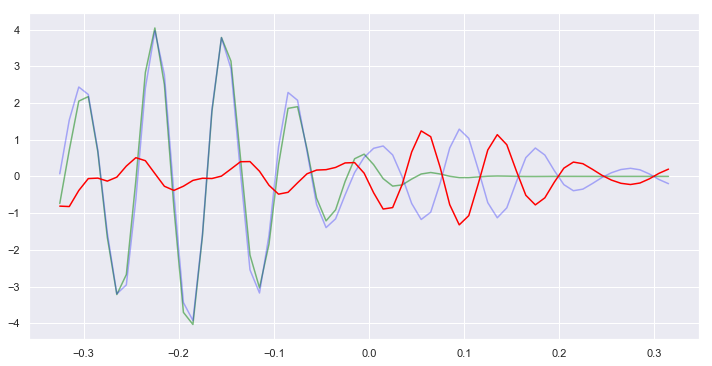

In [293]:
# Plot the fitted QPS model:
model_fitted = qps_time_sig(t_qps, a=a, b=b, c=c, d=d, e=e, f=f)

# Plot the prototype QPS model:
fig = plt.figure(figsize=(12,6))
plt.plot(t_qps, model_fitted, color='green', alpha=0.5)
plt.plot(t_qps, marked_spindle_filtered, color='blue', alpha=0.3)
plt.plot(t_qps, model_fitted - marked_spindle_filtered, color='red', alpha=1.0)
plt.show()

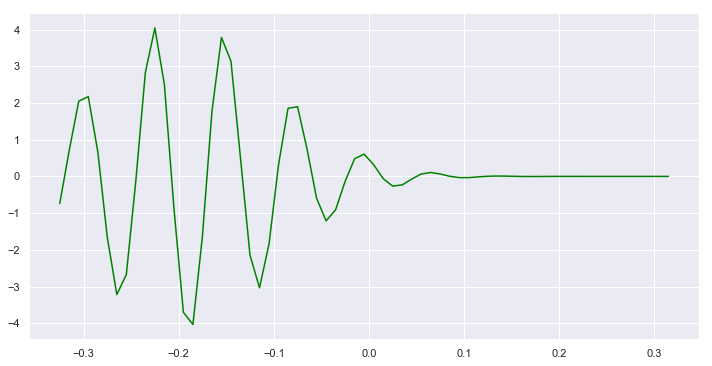

In [294]:
# Plot the prototype QPS model (alone):
fig = plt.figure(figsize=(12,6))
plt.plot(t_qps, model_fitted, color='green', alpha=1.0)
plt.show()

In [295]:
dict_params

{'a': -0.6055709516403661,
 'b': -21.195103758472747,
 'c': -54.57568903608355,
 'd': 38.128236156582,
 'e': 86.25981011525468,
 'f': 4.230766460855529}

In [296]:
param_df = pd.DataFrame(dict_params, index=['i',])
param_df

,a,b,c,d,e,f
i,-0.605571,-21.195104,-54.575689,38.128236,86.25981,4.230766


In [297]:
param_df.to_clipboard()

# 